In [123]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np 

import os 
import re
import glob
import random

from skimage.transform import rotate
from skimage.filters import gaussian

In [5]:
img_file_list = glob.glob("../data/*.png")
disk_file_list = glob.glob('../data/contour/1/*.png')
macular_file_list = glob.glob('../data/contour/3/*.png')

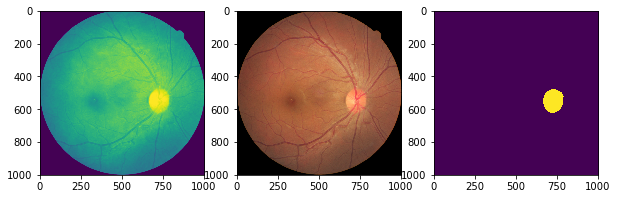

In [62]:
index = index+1
img = cv2.imread(img_file_list[index])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(131)
ax.imshow(img[...,0])
ax = fig.add_subplot(132)
ax.imshow(img)

file_name = os.path.split(img_file_list[index])[1]

disk_file_path = os.path.join("../data/contour/1/",file_name)
if disk_file_path in disk_file_list:
    ax = fig.add_subplot(133)
    mask = cv2.imread(disk_file_path,0)
    ax.imshow(mask)
    
plt.show()

### Data_provider를 만들자

In [200]:
img_dir = '../data/image'
disk_dir = '../data/contour/1/'
macular_dir = '../data/contour/3/'

In [305]:
class DataProvider(object):
    file_list = []
    max_index = 0
    index = 0 
    def __init__(self,img_dir,mask_dir,**kwargs):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.rotate_range = kwargs.get('rotate_range',(1,360))
        self.img_size = kwargs.get('img_size',(256,256))
        self.g_size = kwargs.get('gaussian_size',1)
        self.file_list = list(set(os.listdir(self.img_dir))&set(os.listdir(self.mask_dir)))

        print('the number of input data : {}'.format(len(self.file_list)))
        self.max_index = len(self.file_list) - 1
        self.index = 0

    def _get_next_image(self):
        file_name = self.file_list[self.index]
        # if self.index is out of bound , shuffle list and initalize
        if self.index <= self.max_index:
            self.index += 1
        else:
            random.shuffle(self.file_list)
            self.index = 0

        img_path = os.path.join(self.img_dir,file_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self._normalize_data(img)

        mask_path = os.path.join(self.mask_dir,file_name)
        mask = cv2.imread(mask_path,0)
        mask = self._normalize_data(mask)

        img, mask = self._resize_data(img,mask)

        inv_mask = np.ones_like(mask) - mask
        mask = np.stack([inv_mask,mask],axis=-1)
        return img, mask

    def _normalize_data(self,img):
        norm_img = np.zeros_like(img)
        try:
            norm_img = cv2.normalize(img,norm_img,alpha=0,beta=1,
                                 norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)    
        except TypeError as e:

            print(norm_img.shape)
            print(norm_img)
            norm_img = (norm_img - norm_img.min())/(norm_img.max()-norm_img.min())
        return norm_img

    def _resize_data(self,img,mask):
        img = cv2.resize(img,self.img_size)
        mask = cv2.resize(mask,self.img_size)
        return img, mask

    def _augument_data(self,img,mask):
        # rotate image
        angle = random.randint(*(self.rotate_range))
        img = rotate(img, angle)
        for idx in range(mask.shape[-1]):
            cval = 1 if idx==0 else 0
            mask[...,idx] = rotate(mask[...,idx],angle,cval=cval)
        # apply gaussian blur 
        img = gaussian(img,sigma=self.g_size,multichannel=True)
        return img, mask

    def __call__(self,n):
        imgs = []
        masks = []
        for _ in range(n):
            img, mask = self._get_next_image()
            img, mask = self._augument_data(img, mask)
            imgs.append(img)
            masks.append(mask)

        batch_img = np.stack(imgs)
        batch_mask = np.stack(masks)
        return batch_img, batch_mask

In [306]:
img_dir = '../data/image'
disk_dir = '../data/contour/1/'
macular_dir = '../data/contour/3/'
x = DataProvider(img_dir,disk_dir)

the number of input data : 488


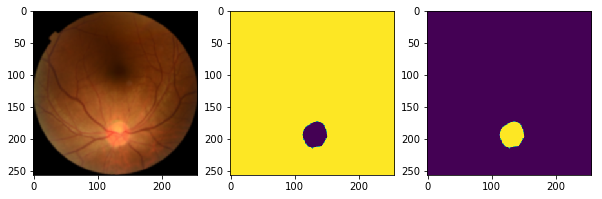

In [329]:
a,b = x(1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(131)
ax.imshow(a[0,...])
ax = fig.add_subplot(132)
ax.imshow(b[0,...,0])
ax = fig.add_subplot(133)
ax.imshow(b[0,...,1])